# Section 5 : Multispectral Remote Sensing Data in Python
## Chapter 11 : Vegetation Indices

[![Foo](https://www.colorado.edu/brand/sites/default/files/styles/medium/public/page/boulder-one-line_0.png)](https://www.earthdatascience.org/courses/use-data-open-source-python/multispectral-remote-sensing/)

Les techniques et considérations de ce notebook se dirigent plus vers l'objectif final du répertoire [Index3](https://github.com/vintel38/Index3). En effet, il est question d'indices végétals qui peuvent efficacement décrire la qualité et la santé de la végétation sur une image de télédétection. En liant des concepts de biologie et de physique générale, on s'aperçoit qu'une végétation en bonne santé réfléchit beaucoup plus de rayonnement dans le proche infrarouge (NIR) alors que le visible est absorbé par la matière végétale. Ainsi, si on définit des valeurs adimensionnées concernant la part de rayonnement capté par l'observateur qui enregistre la séquence, on peut alors déduire des informations sur la présence de végétation, et si elle est avérée, caractériser la santé de la végétation tout ça à partir d'un cliché de télédétection multispectral. 

## NDVI - Normalized Differential Vegetation Index 

Le premier indicateur que l'on peut mettre à jour est le NDVI. Une végétation en bonne santé rayonne beaucoup dans l'infrarouge proche (NIR) et peu dans le visible. A noter que cet écart est moindre quand la végétation est en mauvaise santé. De fait, on peut définir un critère pour décrire l'état de santé de la plante. On s'intéresse à la différence entre le rayonnement capté dans le NIR et celui capté dans le visible représenté ici par la bande spectrale rouge. On normalise ensuite la différence par la somme pour obtenir un nombre adimensionné:

$$
NDVI = \frac{\Psi_{NIR}-\Psi_{Red}}{\Psi_{NIR}+\Psi_{Red}}
$$ 

avec $\Psi$ étant la réflectance reçue par l'observateur pour chaque pixel. Note: en réalité, le terme réflectance fait référence au nombre adimensionnel qui évalue la quantité d'énergie radiative (ou flux lumineux) réfléchie par une surface divisée par la quantité d'énergie radiative incidente. On utilise la notation du document d'origine et on supposera dans la suite que $\Psi$ représente le flux lumineux réfléchi pour pouvoir utiliser facilement les clichés sur les différentes bandes spectrales. 

Dans ce notebook, nous utiliserons donc l'indicateur NDVI pour caractériser la distribution de végétation sur des images de télédétection. Cet indicateur varie entre 0 et 1 où 0 représente une végétation flétrie et 1 une végétation luxuriante. 

In [21]:
import os

import matplotlib.pyplot as plt
from glob import glob
import numpy as np
from numpy import ma
import xarray as xr
import rioxarray as rxr
import geopandas as gpd
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

# Download data and set working directory
data = et.data.get_data('cold-springs-fire')
os.chdir(os.path.join(et.io.HOME, 'earth-analytics', 'data'))


## **Cold Springs - 2015 - NAIP pictures**
***
On commence par l'exemple du notebook qui est une image délivrée par le NAIP pour *National Agriculture Imagery Program*, une agence fédérale américaine qui prend des clifchés aériens de zones agricoles pour générer des donneés à compiler sur les capacités de production agricoles américaines. Le fichier `.tif` à extraire contient toutes les bandes spectrales du cliché aérien. On utilise donc la fonction `rioxarray.open_rasterio()` pour importer le cliché NAIP. Les données extraites sont un tableau à 4 dimensions qui correspondent au rouge, vert, bleu, infrarouge proche sans que les plages spectrales ne soient renseignées sur le site du notebook. 

In [2]:
naip_data_path = os.path.join("cold-springs-fire",
                              "naip",
                              "m_3910505_nw_13_1_20150919",
                              "crop",
                              "m_3910505_nw_13_1_20150919_crop.tif")

naip_data = rxr.open_rasterio(naip_data_path)

# View shape of the data
naip_data.shape

(4, 2312, 4377)

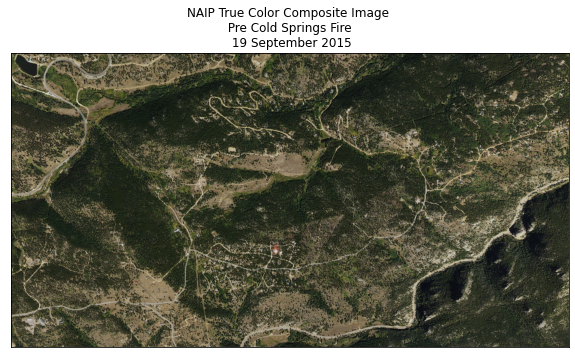

In [3]:
ep.plot_rgb(naip_data.values,
            rgb=[0, 1, 2],
            title="NAIP True Color Composite Image \n Pre Cold Springs Fire \n 19 September 2015")

plt.show()

***
La fonction préimplémentée `earthpy.spatial.normalized_diff()` permet de réaliser simplement le calcul de l'indicateur NDVI entre les flux lumineux de la dernière (NIR) et de la première (Red) bande spectrale sur l'entièreté de l'image aérienne. Enfin, l'image résultante est affichée classiquement avec la fonction `earthpy.plot.plot_bands()` en utilisant la cartographie de couleurs *PiYG* pour facilement identifier les zones avec des valeurs extrémales. 

Après avoir normalisé la plage de valeurs de NDVI entre -1 et 1 qui représente la plage de valeur maximale atteignable pour les sols végétalisés ou non, on  s'aperçoit que l'image est étrangement claire comme sur le [notebook](https://www.earthdatascience.org/courses/use-data-open-source-python/multispectral-remote-sensing/vegetation-indices-in-python/calculate-NDVI-python/) d'origine, ce qui signifierait que la végétation sur cette parcelle est en très mauvaise santé. A première vue, cette observation est contradictoire étant donné que l'affichage du site en vraies couleurs (voir ci-dessus) laisse apparaître de larges portions de l'image verdoyantes. Si on commente la ligne de `vmin` et `vmax`, on s'aperçoit que l'affichage reprend des couleurs pour ainsi dire. En effet, la plage de valeur min et max de `naip_ndvi` est assez étroite entre \[-0.64;0.55\] et `vmin` et `vmax`, contrairement à ce qui est indiqué dans le [notebook](https://www.earthdatascience.org/courses/use-data-open-source-python/multispectral-remote-sensing/vegetation-indices-in-python/calculate-NDVI-python/), vont se contenter de définir la plage de tracé de la fonction `matplotlib.pyplot.imshow()` sans provoquer d'homotéthie (pas de stretching de la plage de valeur). La plage de valeur initiale étroite centrée autour de 0 se retrouve dans une plage de tracé plus vaste toujours centrée autour de 0 donc on obtient une visualisation moins colorée. 

Cette visualisation assez étrange peut nous interroger sur les données issues de NAIP par rapport à celles de Landsat8. En effet, les bandes spectrales d'observation de la NAIP ne sont mentionnées nul part et donc il se pourrait que une observation de la même parcelle avec Landsat8 donne des résultats totalement différents avec des valeurs de l'indicateur NDVI plus élevées. 

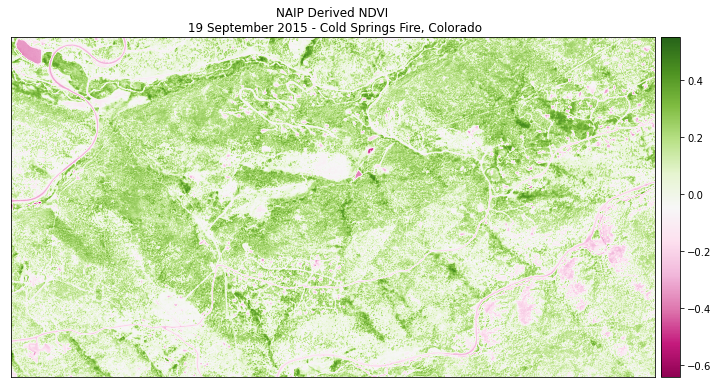

In [4]:
naip_ndvi = es.normalized_diff(naip_data[3], naip_data[0])

ep.plot_bands(naip_ndvi,
              cmap='PiYG',
              scale=False,
              #vmin=-1, vmax=1,
              title="NAIP Derived NDVI\n 19 September 2015 - Cold Springs Fire, Colorado")
plt.show()

***
On peut ici tracer un histogramme des valeurs NDVI pour observer leur distribution. On s'aperçoit que la majorité des pixels sont situés dans la partie positive de la plage de valeurs ce qui démontre une couverture du sol majoritairement végétale. Cependant, beaucoup de valeurs se situent autour de 0 ce qui montre une végétation qui peine à se développer dans certains endroits.

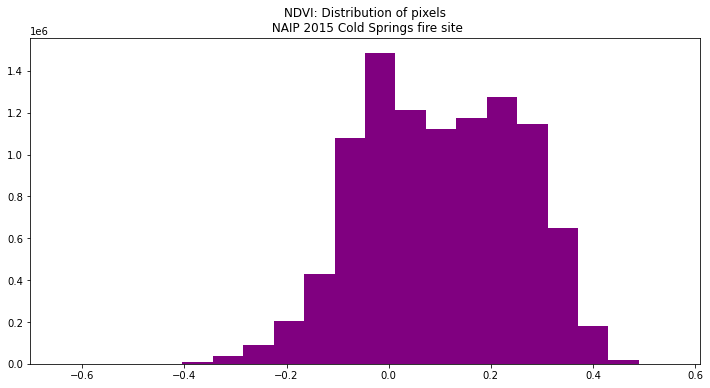

In [9]:
ep.hist(naip_ndvi.values,
        figsize=(12, 6),
        title=["NDVI: Distribution of pixels\n NAIP 2015 Cold Springs fire site"])

plt.show()

In [11]:
type(naip_ndvi), naip_ndvi.dtype

(xarray.core.dataarray.DataArray, dtype('float64'))

***
Finalement, pour réutiliser ce traitement de la donnée par la suite ou à des fins de communication, le tableau `naip_ndvi` qui contient la cartographie de Cold Springs de l'indicateur NDVI peut enregistrer au format `.tif` en spécifiant le chemin d'accès. Le format `.tif` permet de stocker des images sans pertes d'information. 

In [12]:
naip_ndvi_outpath = os.path.join("cold-springs-fire",
                                 "outputs",
                                 "naip_ndvi.tif")

# Write your the ndvi raster object
naip_ndvi.rio.to_raster(naip_ndvi_outpath)

## **Cold Springs - 2016 - Landsat pictures**
***
Dans la seconde partie de ce notebook, on s'intéresse aux clichés Landsat déjà utilisés dans les notebooks précédents. Il est intéressant de réaliser la procédure pour récupérer l'indicateur NDVI sur les clichés précédents. 

Classiquement, on commence par importer les bandes spectrales du cliché original. A noter que le code n'est pas optimisé comme on aurait pu se contenter d'importer seulement les bandes spectrales rouge et proche infrarouge nécessaires pour le calcul de l'indicateur NDVI mais cela n'a pas d'effets dramatiques dans l'absolu étant donné le degré de complexité du programme. On réalise les opérations maintenant maîtrisées pour assembler le tableau multi-dimensionnel de l'image Landsat avant de l'afficher en vraies couleurs. 

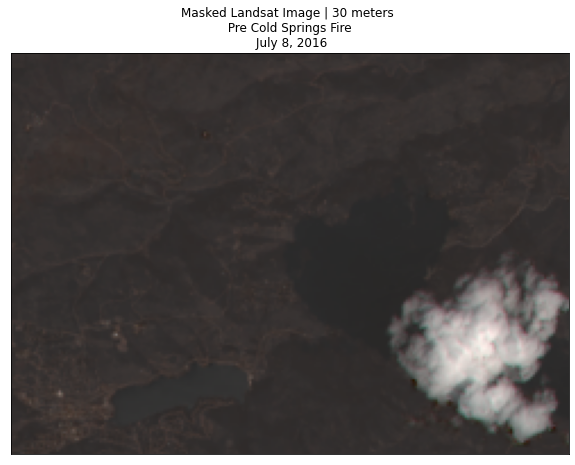

In [29]:
#Custom function to read in list of tifs into an xarray object
def combine_tifs(tif_list):
    out_xr=[]
    for i, tif_path in enumerate(tif_list):
        out_xr.append(rxr.open_rasterio(tif_path, masked=True).squeeze())
        out_xr[i]["band"]=i+1
     
    return xr.concat(out_xr, dim="band") 

# Stack the Landsat pre fire data
landsat_paths_pre_path = os.path.join("cold-springs-fire", 
                                      "landsat_collect",
                                      "LC080340322016070701T1-SC20180214145604", 
                                      "crop",
                                      "*band*.tif")

landsat_paths_pre = glob(landsat_paths_pre_path)
landsat_paths_pre.sort()

landsat_pre_cloud = combine_tifs(landsat_paths_pre)

ep.plot_rgb(landsat_pre_cloud.values,
            rgb=[2, 1, 0],
            title="Masked Landsat Image | 30 meters \n Pre Cold Springs Fire \n July 8, 2016")
plt.show()


***
On peut maintenant calculer la cartographie de l'indicateur NVDI avec la fonction `earthpy.spatial.normalized_diff` et on se rend compte que le résultat a une teinte verte beaucoup plus prononcée que l'image NAIP précédente. Etant donné le peu d'information disponible sur les plages d'observation spectrales de NAIP, la comparaison n'est pas vraiment utile dans ce cas là. On peut juste dire que la végétation est globalement en bonne santé sur cette parcelle. Cependant, le nuage pose toujours problème si on veut faire une analyse quantitative de la végétation du sol. 

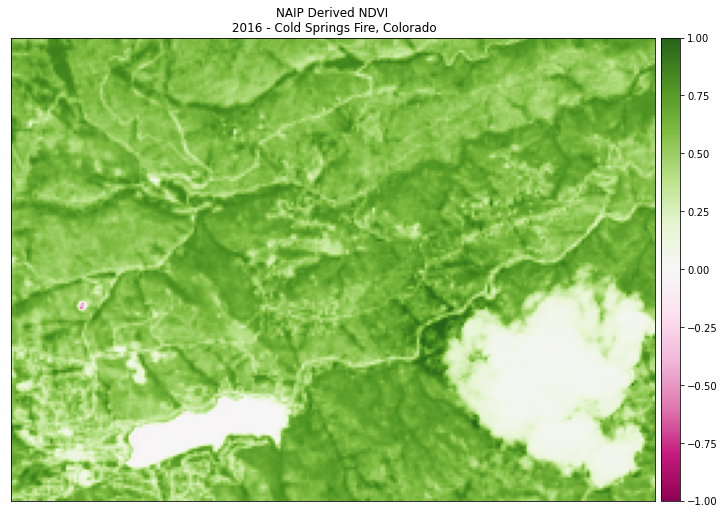

In [26]:
landsat_ndvi = es.normalized_diff(landsat_pre_cloud[4], landsat_pre_cloud[3])

ep.plot_bands(landsat_ndvi,
              cmap='PiYG',
              scale=False,
              vmin=-1, vmax=1,
              title="NAIP Derived NDVI\n 2016 - Cold Springs Fire, Colorado")
plt.show()

In [18]:
np.average(naip_ndvi2)

0.546073855193897

In [19]:
np.count_nonzero(~np.isnan(naip_ndvi2))

43542

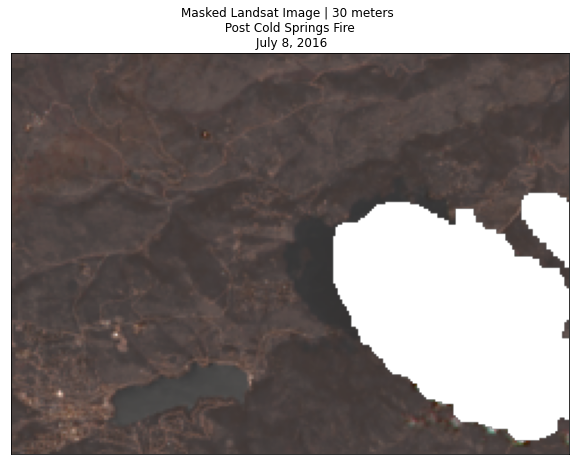

In [22]:

# Calculate bounds object
landsat_pre_cloud_ext_bds = landsat_pre_cloud.rio.bounds()

# Open the pixel_qa layer for your landsat scene
landsat_pre_cl_path = os.path.join("cold-springs-fire", 
                                   "landsat_collect",
                                   "LC080340322016070701T1-SC20180214145604", 
                                   "crop",
                                   "LC08_L1TP_034032_20160707_20170221_01_T1_pixel_qa_crop.tif")

landsat_qa = rxr.open_rasterio(landsat_pre_cl_path).squeeze()

# Generate array of all possible cloud / shadow values
cloud_shadow = [328, 392, 840, 904, 1350]
cloud = [352, 368, 416, 432, 480, 864, 880, 928, 944, 992]
high_confidence_cloud = [480, 992]

vals_to_mask = cloud_shadow + cloud + high_confidence_cloud

# Call the earthpy mask function using pixel QA layer
landsat_pre_cloud_masked = landsat_pre_cloud.where(~landsat_qa.isin(vals_to_mask))

# Masking out NA values with numpy in order to plot with ep.plot_rgb
landsat_pre_cloud_masked_plot = ma.masked_array(landsat_pre_cloud_masked.values, landsat_pre_cloud_masked.isnull())

ep.plot_rgb(landsat_pre_cloud_masked_plot,
            rgb=[2, 1, 0],
            title="Masked Landsat Image | 30 meters \n Post Cold Springs Fire \n July 8, 2016")
plt.show()


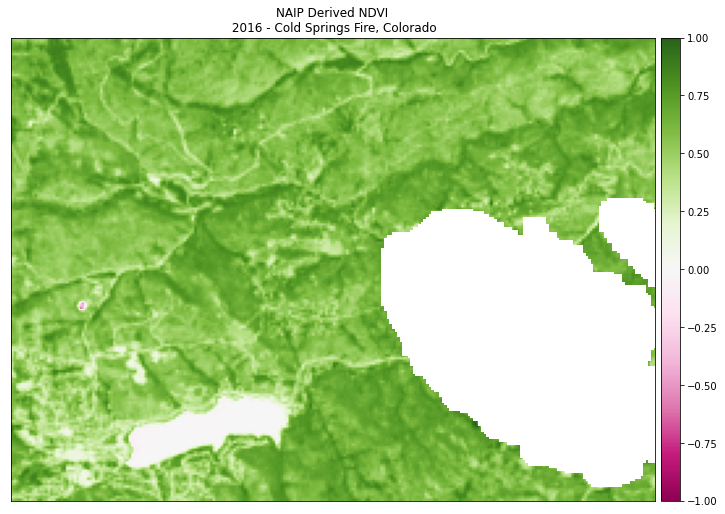

In [28]:
CS_ndvi = es.normalized_diff(landsat_pre_cloud_masked_plot[4], landsat_pre_cloud_masked_plot[3])

ep.plot_bands(CS_ndvi,
              cmap='PiYG',
              scale=False,
              vmin=-1, vmax=1,
              title="NAIP Derived NDVI\n 2016 - Cold Springs Fire, Colorado")
plt.show()

In [24]:
np.average(CS_ndvi)

0.5809856874450827

In [25]:
np.count_nonzero(~np.isnan(CS_ndvi))

35394

prend une partie de la végétation sous l'ombre portée du nuage donc ca compense la disparition des pixels blancs du nuage et la moyenne reste faible 

De plus zone dans l'ombre portée du nuage plus verte que le reste donc soit est très végétalisée soit la mesure est modifiée par la réflection de la lumière solaire sur la végétation. 